In [ ]:
#google cloud platform
pip install --upgrade google-cloud-vision

In [4]:
import os
import io
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from utils import plt_imshow
import matplotlib.pyplot as plt
 
import cv2
from google.cloud import vision

from gtts import gTTS
from IPython.display import Audio 

## ocr

In [5]:
def google_ocr(img):
    
    #글자 인식
    def plt_imshow(title='image', img=None, figsize=(8 ,5)):
        plt.figure(figsize=figsize)

        if type(img) == list:
            if type(title) == list:
                titles = title
            else:
                titles = []

                for i in range(len(img)):
                    titles.append(title)

            for i in range(len(img)):
                if len(img[i].shape) <= 2:
                    rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
                else:
                    rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

                plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
                plt.title(titles[i])
                plt.xticks([]), plt.yticks([])

            plt.show()
        else:
            if len(img.shape) < 3:
                rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.imshow(rgbImg)
            plt.title(title)
            plt.xticks([]), plt.yticks([])
            plt.show()

    #글자 출력
    def putText(image, text, x, y, color=(0, 255, 0), font_size=22):
        if type(image) == np.ndarray:
            color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(color_coverted)

        if platform.system() == 'Darwin':
            font = 'AppleGothic.ttf'
        elif platform.system() == 'Windows':
            font = 'malgun.ttf'

        image_font = ImageFont.truetype(font, font_size)
        font = ImageFont.load_default()
        draw = ImageDraw.Draw(image)

        draw.text((x, y), text, font=image_font, fill=color)

        numpy_image = np.array(image)
        opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

        return opencv_image

    #google cloud platform api 가져오기
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google cloud platform.json 키 입력'
 
    client_options = {'api_endpoint': 'eu-vision.googleapis.com'}
    client = vision.ImageAnnotatorClient(client_options=client_options)
    
    #이미지 경로
    path = '{}'.format(img)
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    #ocr
    image = vision.Image(content=content)
 
    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    #읽어와서 출력 
    img = cv2.imread(path)
    roi_img = img.copy()

    for text in texts:
        print('\n"{}"'.format(text.description))

        vertices = (['({},{})'.format(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices])

        ocr_text = text.description
        x1 = text.bounding_poly.vertices[0].x
        y1 = text.bounding_poly.vertices[0].y
        x2 = text.bounding_poly.vertices[1].x
        y2 = text.bounding_poly.vertices[2].y

        cv2.rectangle(roi_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
        roi_img = putText(roi_img, ocr_text, x1, y1 - 30, font_size=30)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))
     
    #음성 파일 생성
    kor_wav = gTTS('{}'.format(texts[0].description), lang = 'ko') 
    kor_wav.save('./voice.wav')

    display(Audio('./voice.wav', autoplay=True))
    
    def sound():
        display(Audio('./voice.wav', autoplay=True))


"어린이
보호구역
30"

"어린이"

"보호"

"구역"

"30"


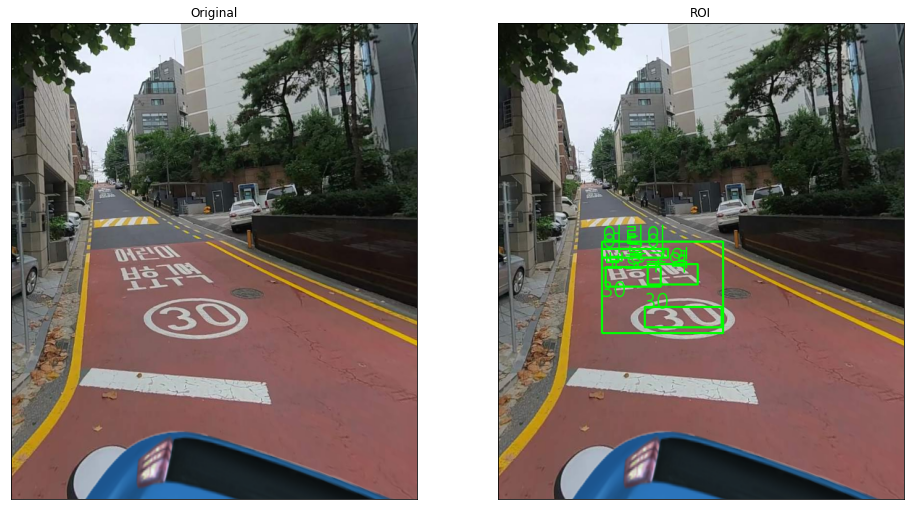

In [6]:
google_ocr('roadview.png')